### Import Required Packages

In [1]:
# ---------------------------- STEP 1: Import Packages ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

# Device Setup (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# ---------------------------- STEP 2 & 3: Drive Import + Transformations ----------------------------
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [17]:
# ---------------------------- STEP 4: Dataset Path + Loader ----------------------------
train_path = "/content/drive/MyDrive/Smart Vison AI/classification/train"
test_path  = "/content/drive/MyDrive/Smart Vison AI/classification/test"


train_ds = datasets.ImageFolder(train_path, transform=train_tf)
test_ds  = datasets.ImageFolder(test_path, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

classes = train_ds.classes
num_classes = len(classes)
print("Classes:", classes)


Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']


In [18]:
# ---------------------------- STEP 5: Load Pretrained VGG16 + Freeze + Custom Classifier ----------------------------
vgg16 = models.vgg16(pretrained=True)

# Freeze base feature layers
for param in vgg16.features[-6:].parameters():
    param.requires_grad = True

# Custom classifier
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

vgg16 = vgg16.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# ---------------------------- STEP 6: Optimizer + Loss Function ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)


In [21]:
# ---------------------------- STEP 7: Training Loop ----------------------------
epochs = 20

for epoch in range(epochs):
    start = time.time()
    vgg16.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | Train Acc: {train_acc:.2f}% | Time: {elapsed:.2f}s")


Epoch 1/20 | Loss: 67.509 | Train Acc: 32.83% | Time: 16.10s
Epoch 2/20 | Loss: 28.808 | Train Acc: 70.33% | Time: 15.55s
Epoch 3/20 | Loss: 17.270 | Train Acc: 81.07% | Time: 15.71s
Epoch 4/20 | Loss: 12.711 | Train Acc: 85.16% | Time: 14.67s
Epoch 5/20 | Loss: 9.604 | Train Acc: 89.37% | Time: 13.67s
Epoch 6/20 | Loss: 8.030 | Train Acc: 90.77% | Time: 13.71s
Epoch 7/20 | Loss: 6.441 | Train Acc: 92.76% | Time: 14.40s
Epoch 8/20 | Loss: 4.680 | Train Acc: 95.09% | Time: 13.79s
Epoch 9/20 | Loss: 4.869 | Train Acc: 94.86% | Time: 13.89s
Epoch 10/20 | Loss: 3.929 | Train Acc: 95.33% | Time: 13.90s
Epoch 11/20 | Loss: 3.657 | Train Acc: 96.03% | Time: 14.01s
Epoch 12/20 | Loss: 2.358 | Train Acc: 97.78% | Time: 13.98s
Epoch 13/20 | Loss: 2.225 | Train Acc: 97.55% | Time: 14.02s
Epoch 14/20 | Loss: 1.463 | Train Acc: 98.48% | Time: 14.06s
Epoch 15/20 | Loss: 2.060 | Train Acc: 97.90% | Time: 14.38s
Epoch 16/20 | Loss: 1.666 | Train Acc: 98.25% | Time: 14.64s
Epoch 17/20 | Loss: 1.859 | T

In [22]:
# ---------------------------- STEP 8: Test Accuracy ----------------------------
vgg16.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")



Test Accuracy = 88.04%


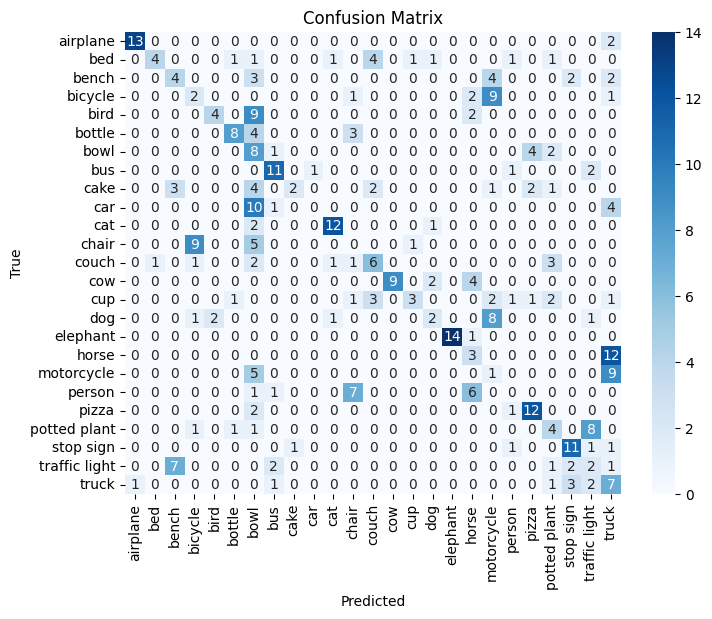


Classification Report:

               precision    recall  f1-score   support

     airplane       0.93      0.87      0.90        15
          bed       0.80      0.27      0.40        15
        bench       0.29      0.27      0.28        15
      bicycle       0.14      0.13      0.14        15
         bird       0.67      0.27      0.38        15
       bottle       0.73      0.53      0.62        15
         bowl       0.14      0.53      0.22        15
          bus       0.65      0.73      0.69        15
         cake       0.67      0.13      0.22        15
          car       0.00      0.00      0.00        15
          cat       0.80      0.80      0.80        15
        chair       0.00      0.00      0.00        15
        couch       0.40      0.40      0.40        15
          cow       1.00      0.60      0.75        15
          cup       0.60      0.20      0.30        15
          dog       0.33      0.13      0.19        15
     elephant       1.00      0.93     

In [ ]:
# ---------------------------- STEP 8: Confusion Matrix ----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
import os

save_path = "/content/drive/MyDrive/VGG16-3-12-27/11/25Smart Vision.pth"

save_dir = os.path.dirname(save_path)

os.makedirs(save_dir, exist_ok=True)

torch.save(vgg16.state_dict(), save_path)
print("Model saved to Google Drive:", save_path)

Model saved to Google Drive: /content/drive/MyDrive/VGG16-3-12-27/11/25Smart Vision.pth


In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Freeze feature extractor (convolution backbone)
for param in model.features[-6:].parameters():
    param.requires_grad = True

# Replace classifier for your number of categories
num_classes = len(classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)


In [ ]:
epochs = 10
best_val_acc = 0

for epoch in range(epochs):
    start = time.time()
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Time: {elapsed:.2f}s")


Epoch 1/10 | Loss: 177.232 | Train Acc: 4.00% | Val Acc: 5.87% | Time: 21.21s
Epoch 2/10 | Loss: 177.289 | Train Acc: 5.37% | Val Acc: 5.87% | Time: 21.57s
Epoch 3/10 | Loss: 177.521 | Train Acc: 4.06% | Val Acc: 5.07% | Time: 21.67s
Epoch 4/10 | Loss: 177.334 | Train Acc: 4.63% | Val Acc: 5.60% | Time: 20.97s
Epoch 5/10 | Loss: 177.399 | Train Acc: 4.11% | Val Acc: 7.20% | Time: 22.29s
Epoch 6/10 | Loss: 177.573 | Train Acc: 4.46% | Val Acc: 5.87% | Time: 21.78s
Epoch 7/10 | Loss: 177.221 | Train Acc: 4.80% | Val Acc: 4.80% | Time: 21.66s
Epoch 8/10 | Loss: 177.345 | Train Acc: 4.11% | Val Acc: 6.67% | Time: 21.65s
Epoch 9/10 | Loss: 177.143 | Train Acc: 5.26% | Val Acc: 5.87% | Time: 21.33s
Epoch 10/10 | Loss: 177.326 | Train Acc: 4.29% | Val Acc: 5.33% | Time: 21.50s



Test Accuracy = 5.33%


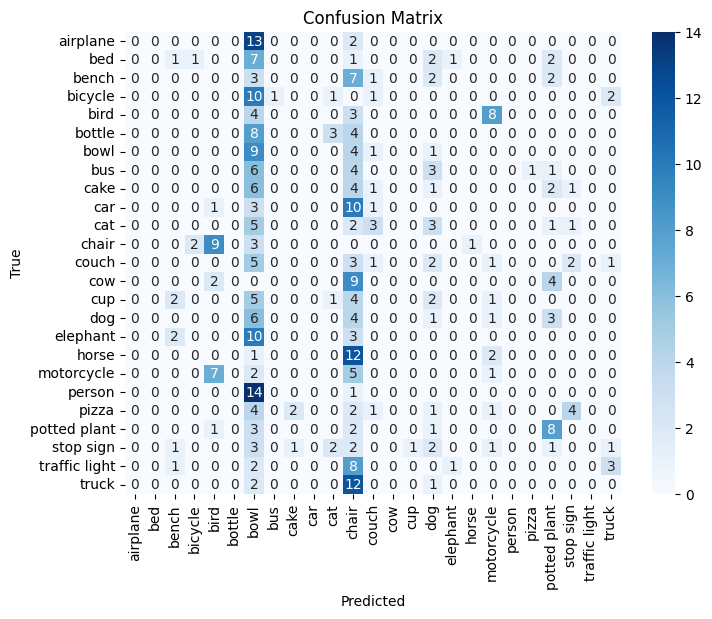


Classification Report:

               precision    recall  f1-score   support

     airplane       0.00      0.00      0.00        15
          bed       0.00      0.00      0.00        15
        bench       0.00      0.00      0.00        15
      bicycle       0.00      0.00      0.00        15
         bird       0.00      0.00      0.00        15
       bottle       0.00      0.00      0.00        15
         bowl       0.07      0.60      0.12        15
          bus       0.00      0.00      0.00        15
         cake       0.00      0.00      0.00        15
          car       0.00      0.00      0.00        15
          cat       0.00      0.00      0.00        15
        chair       0.00      0.00      0.00        15
        couch       0.10      0.07      0.08        15
          cow       0.00      0.00      0.00        15
          cup       0.00      0.00      0.00        15
          dog       0.05      0.07      0.05        15
     elephant       0.00      0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
import os

save_path = "/content/drive/MyDrive/EFFICINET-3-20-27/11/25Smart Vision.pth"

save_dir = os.path.dirname(save_path)

os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), save_path)
print("Model saved to Google Drive:", save_path)

In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for your dataset
num_classes = len(classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 141MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)


In [ ]:
epochs = 25
best_val_acc = 0

for epoch in range(epochs):
    start = time.time()
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Time: {elapsed:.2f}s")


Epoch 1/25 | Loss: 56.506 | Train Acc: 68.63% | Val Acc: 41.07% | Time: 17.78s
Epoch 2/25 | Loss: 55.392 | Train Acc: 70.46% | Val Acc: 41.87% | Time: 15.78s
Epoch 3/25 | Loss: 57.156 | Train Acc: 69.26% | Val Acc: 41.87% | Time: 15.69s
Epoch 4/25 | Loss: 55.306 | Train Acc: 69.89% | Val Acc: 44.27% | Time: 15.87s
Epoch 5/25 | Loss: 54.783 | Train Acc: 70.57% | Val Acc: 42.93% | Time: 16.03s
Epoch 6/25 | Loss: 53.948 | Train Acc: 71.37% | Val Acc: 42.93% | Time: 15.55s
Epoch 7/25 | Loss: 55.537 | Train Acc: 70.34% | Val Acc: 41.60% | Time: 16.03s
Epoch 8/25 | Loss: 54.676 | Train Acc: 71.20% | Val Acc: 43.20% | Time: 15.56s
Epoch 9/25 | Loss: 54.983 | Train Acc: 70.11% | Val Acc: 41.87% | Time: 16.20s
Epoch 10/25 | Loss: 53.008 | Train Acc: 71.89% | Val Acc: 42.13% | Time: 15.93s
Epoch 11/25 | Loss: 55.506 | Train Acc: 69.43% | Val Acc: 43.20% | Time: 15.58s
Epoch 12/25 | Loss: 54.164 | Train Acc: 71.66% | Val Acc: 40.27% | Time: 15.56s
Epoch 13/25 | Loss: 52.479 | Train Acc: 71.71% | 


Test Accuracy = 34.67%


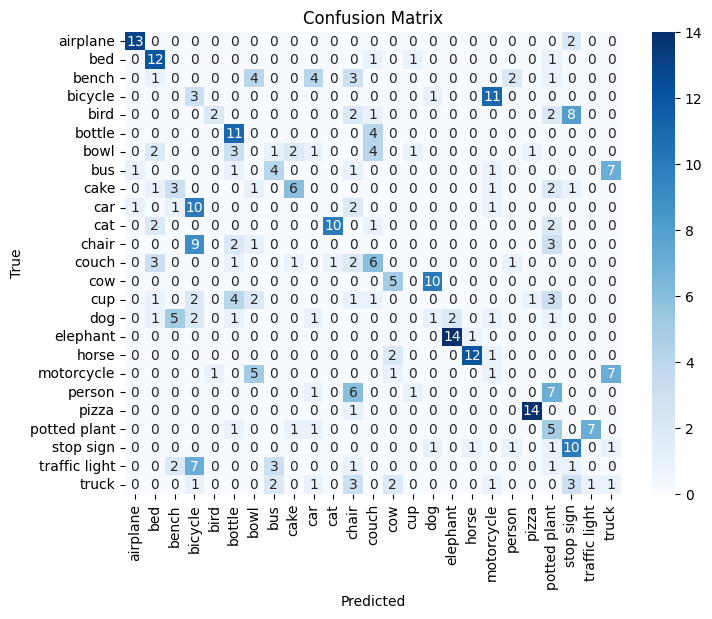


Classification Report:

               precision    recall  f1-score   support

     airplane       0.87      0.87      0.87        15
          bed       0.52      0.80      0.63        15
        bench       0.00      0.00      0.00        15
      bicycle       0.09      0.20      0.12        15
         bird       0.67      0.13      0.22        15
       bottle       0.46      0.73      0.56        15
         bowl       0.00      0.00      0.00        15
          bus       0.40      0.27      0.32        15
         cake       0.60      0.40      0.48        15
          car       0.00      0.00      0.00        15
          cat       0.91      0.67      0.77        15
        chair       0.00      0.00      0.00        15
        couch       0.33      0.40      0.36        15
          cow       0.50      0.33      0.40        15
          cup       0.00      0.00      0.00        15
          dog       0.08      0.07      0.07        15
     elephant       0.88      0.93     

In [ ]:
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")

# Confusion matrix + classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
import os

save_path = "/content/drive/MyDrive/MobileNET-3-20-27/11/25Smart Vision.pth"

save_dir = os.path.dirname(save_path)

os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), save_path)
print("Model saved to Google Drive:", save_path)

Model saved to Google Drive: /content/drive/MyDrive/MobileNET-3-20-27/11/25Smart Vision.pth
